In [1]:
#importing dependencies 
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

#display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
#importing data from SQL
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'
                       .format(postgres_user, postgres_pw, postgres_host,
                              postgres_port, postgres_db))

df = pd.read_sql_query('SELECT * FROM houseprices', con=engine)

engine.dispose()

In [3]:
#one-hot encoding categorical variables and creating correlation matrix
one_hot = pd.get_dummies(df, drop_first=True)
corr_df_0 = one_hot.corr()


#finding and dropping values that have less than 5% correlation in either direction with our target variable to shrink feature space
low_corr = corr_df_0.loc[abs(corr_df_0['saleprice']) < .05]
low_corr = low_corr['saleprice'].index
low_corr_list = [x for x in low_corr]

df_pca = one_hot.drop(low_corr_list, axis=1)

In [4]:
#filling missing values
df_pca['lotfrontage'].fillna(df_pca['lotfrontage'].mean(), inplace=True)
df_pca['garageyrblt'].fillna(df_pca['yearbuilt'], inplace=True)
df_pca['masvnrarea'].fillna(df_pca['masvnrarea'].mean(), inplace=True)

In [5]:
#Performing PCA 
df_pca.dropna(inplace=True)
scaled_df = StandardScaler().fit_transform(df_pca)
sklearn_pca = PCA(n_components=5)
pca_arrays  = sklearn_pca.fit_transform(scaled_df)

df_pca['pca_1'] = pca_arrays[:,0]
df_pca['pca_2'] = pca_arrays[:,1]
df_pca['pca_3'] = pca_arrays[:,2]
df_pca['pca_4'] = pca_arrays[:,3]
df_pca['pca_5'] = pca_arrays[:,4]

In [6]:
#examining absolute value of features most correlated with saleprice
abs(df_pca.corr()['saleprice']).sort_values(ascending=False)

saleprice               1.000
pca_1                   0.808
overallqual             0.791
grlivarea               0.709
garagecars              0.640
                         ... 
exterior1st_WdShing     0.051
exterior1st_BrkComm     0.051
fence_MnWw              0.051
salecondition_AdjLand   0.051
extercond_Gd            0.050
Name: saleprice, Length: 158, dtype: float64

# Model 1

In [7]:
#define target variable
Y = df_pca['saleprice']

#define predictive variables
X = df_pca[['pca_1','overallqual', 'garagearea']]

#splitting data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=465)


In [8]:
#verifying data was split properly 
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1168, 3)
(292, 3)
(1168,)
(292,)


In [9]:
#adding constant to training features
X_train = sm.add_constant(X_train)

#fitting model using training data
model = sm.OLS(y_train, X_train).fit()

#adding constant to testing features
X_test = sm.add_constant(X_test)

#predicting using testing data
y_pred = model.predict(X_test)

#examing OLS regression results
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     1001.
Date:                Thu, 03 Oct 2019   Prob (F-statistic):          1.25e-321
Time:                        18:16:14   Log-Likelihood:                -14081.
No. Observations:                1168   AIC:                         2.817e+04
Df Residuals:                    1164   BIC:                         2.819e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         1.68e+04   1.01e+04      1.663      0.097   -3026.278    3.66e+04
pca_1        7605.5951    586.547     12.967      0.000    6454.788    8756.402
overallqual  2.326e+04   1536.063     15.143      0.000    2.02e+04    2.63e+04
garagearea     47.4803      7.752      6.125      0.000      32.270      62.691
==============================================================================
Omnibus:                      544.692   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8736.073
Skew:                           1.736   Prob(JB):                         0.00
Kurtosis:                      15.940   Cond. No.                     4.35e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.35e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

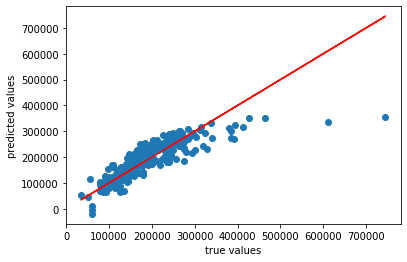

In [10]:
#visualizing our performance
plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test, color='r')
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.show()

In [11]:
#evaluating test metrics

#Mean absolute error 
print('Mean absolute error: {}'.format(mean_absolute_error(y_test, y_pred)))

#Mean squared error
print('Mean squared error: {}'.format(mse(y_test, y_pred)))

#Root mean square error
print('Root mean squared error: {}'.format(rmse(y_test, y_pred)))

#Mean absolute percent error 
print('Mean absolute percent error: {}'.format(np.mean(abs((y_test-y_pred)/y_test)*100)))


Mean absolute error: 29021.975770546556
Mean squared error: 2012310951.2929165
Root mean squared error: 44858.78900831939
Mean absolute percent error: 16.523980931208307


# Model 2

In [12]:
#define target variable
Y = df_pca['saleprice']

#define predictive variables
X = df_pca[['pca_1', 'garagearea', 'wooddecksf', 'yearremodadd']]

#splitting data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=465)

#adding constant to training features
X_train = sm.add_constant(X_train)

#fitting model using training data
model = sm.OLS(y_train, X_train).fit()

#adding constant to testing features
X_test = sm.add_constant(X_test)

#predicting using testing data
y_pred = model.predict(X_test)

#examing OLS regression results
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     598.3
Date:                Thu, 03 Oct 2019   Prob (F-statistic):          2.16e-280
Time:                        18:16:15   Log-Likelihood:                -14173.
No. Observations:                1168   AIC:                         2.836e+04
Df Residuals:                    1163   BIC:                         2.838e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         7.693e+05   1.81e+05      4.260      0.000    4.15e+05    1.12e+06
pca_1         1.483e+04    590.596     25.112      0.000    1.37e+04     1.6e+04
garagearea      42.9264      8.509      5.045      0.000      26.231      59.622
wooddecksf      42.7520     11.343      3.769      0.000      20.496      65.008
yearremodadd  -308.5898     90.599     -3.406      0.001    -486.346    -130.834
==============================================================================
Omnibus:                      573.528   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7492.932
Skew:                           1.933   Prob(JB):                         0.00
Kurtosis:                      14.791   Cond. No.                     2.79e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.79e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

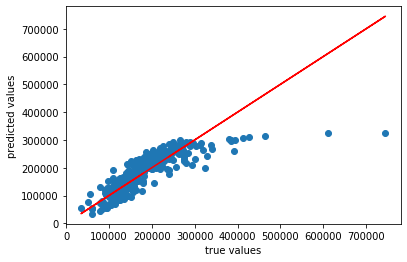

In [13]:
#visualizing our performance
plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test, color='r')
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.show()

In [14]:
#evaluating test metrics

#Mean absolute error 
print('Mean absolute error: {}'.format(mean_absolute_error(y_test, y_pred)))

#Mean squared error
print('Mean squared error: {}'.format(mse(y_test, y_pred)))

#Root mean square error
print('Root mean squared error: {}'.format(rmse(y_test, y_pred)))

#Mean absolute percent error 
print('Mean absolute percent error: {}'.format(np.mean(abs((y_test-y_pred)/y_test)*100)))


Mean absolute error: 30439.230457901827
Mean squared error: 2251539775.3550816
Root mean squared error: 47450.39278399159
Mean absolute percent error: 17.049843741255234


# Model 3

In [15]:
#define target variable
Y = df_pca['saleprice']

#define predictive variables
X = df_pca[['pca_1','overallqual', 'salecondition_AdjLand', 'fence_MnWw', 'garagearea']]

#splitting data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=465)

#adding constant to training features
X_train = sm.add_constant(X_train)

#fitting model using training data
model = sm.OLS(y_train, X_train).fit()

#adding constant to testing features
X_test = sm.add_constant(X_test)

#predicting using testing data
y_pred = model.predict(X_test)

#examing OLS regression results
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     599.8
Date:                Thu, 03 Oct 2019   Prob (F-statistic):          8.83e-319
Time:                        18:16:15   Log-Likelihood:                -14081.
No. Observations:                1168   AIC:                         2.817e+04
Df Residuals:                    1162   BIC:                         2.820e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.665e+04   1.01e+04      1.646      0.100   -3195.736    3.65e+04
pca_1                  7618.6334    587.242     12.974      0.000    6466.459    8770.808
overallqual            2.326e+04   1536.941     15.132      0.000    2.02e+04    2.63e+04
salecondition_AdjLand  2.357e+04   2.96e+04      0.796      0.426   -3.45e+04    8.17e+04
fence_MnWw             3439.9718   1.33e+04      0.259      0.796   -2.26e+04    2.95e+04
garagearea               47.7222      7.762      6.148      0.000      32.493      62.952
==============================================================================
Omnibus:                      544.668   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8744.134
Skew:                           1.736   Prob(JB):                         0.00
Kurtosis:                      15.947   Cond. No.                     1.26e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

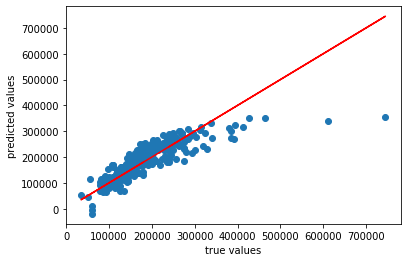

In [16]:
#visualizing our performance
plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test, color='r')
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.show()

In [17]:
#evaluating test metrics

#Mean absolute error 
print('Mean absolute error: {}'.format(mean_absolute_error(y_test, y_pred)))

#Mean squared error
print('Mean squared error: {}'.format(mse(y_test, y_pred)))

#Root mean square error
print('Root mean squared error: {}'.format(rmse(y_test, y_pred)))

#Mean absolute percent error 
print('Mean absolute percent error: {}'.format(np.mean(abs((y_test-y_pred)/y_test)*100)))


Mean absolute error: 29199.703606070383
Mean squared error: 2019549351.0704224
Root mean squared error: 44939.39642530173
Mean absolute percent error: 16.699629106202977


# Discussion

The evaluation of our models shows that model 1 has the best performance with a calculated MAPE of 16.52, the second best prediction accuracy comes from model 3 which has a MAPE of 16.69, the worse is model 2 which has a MAPE of 17.04. We know model 1 is the best model because it has the best prediction score but also has an adjusted R-squared of .720 (the same as model 3), however model 1 uses 3 features to predict performance while model 3 uses 5 features to do so. Thus model one is the simpler and more accurate model for prediction. 